In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [3]:
print(f"Torch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

Torch: 2.6.0.dev20241211+cu126
CUDA: True


In [6]:
batch_size = 64
epochs = 2 # 训练轮次
lr = 3e-5
gamma = 0.7
seed = 42 # 固定随机数

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [9]:
os.makedirs('data', exist_ok=True)

In [10]:
train_dir = r'data\train'
test_dir = r'data\test'

In [11]:
# train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
# test_list = glob.glob(os.path.join(test_dir, '*.jpg'))


def get_image_files(directory):
    """获取指定目录下的所有.jpg文件"""
    image_files = []
    try:
        for filename in os.listdir(directory):
            if filename.lower().endswith('.jpg'):
                image_files.append(os.path.join(directory, filename))
    except OSError as e:
        print(f"Error reading directory {directory}: {e}")
    return image_files

# 使用示例
train_list = get_image_files(train_dir)
test_list = get_image_files(test_dir)

In [12]:
print(f"Train Data: {len(train_list)}, data type: {type(train_list)}, data[0]: {train_list[0]}")
print(f"Test Data: {len(test_list)} , data type: {type(test_list)}")

Train Data: 25000, data type: <class 'list'>, data[0]: data\train\cat.0.jpg
Test Data: 12500 , data type: <class 'list'>


In [13]:
labels = [path.split('\\')[-1].split('.')[0] for path in train_list]
print(f"Labels: {labels[:5]}")  # 打印前5个标签

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


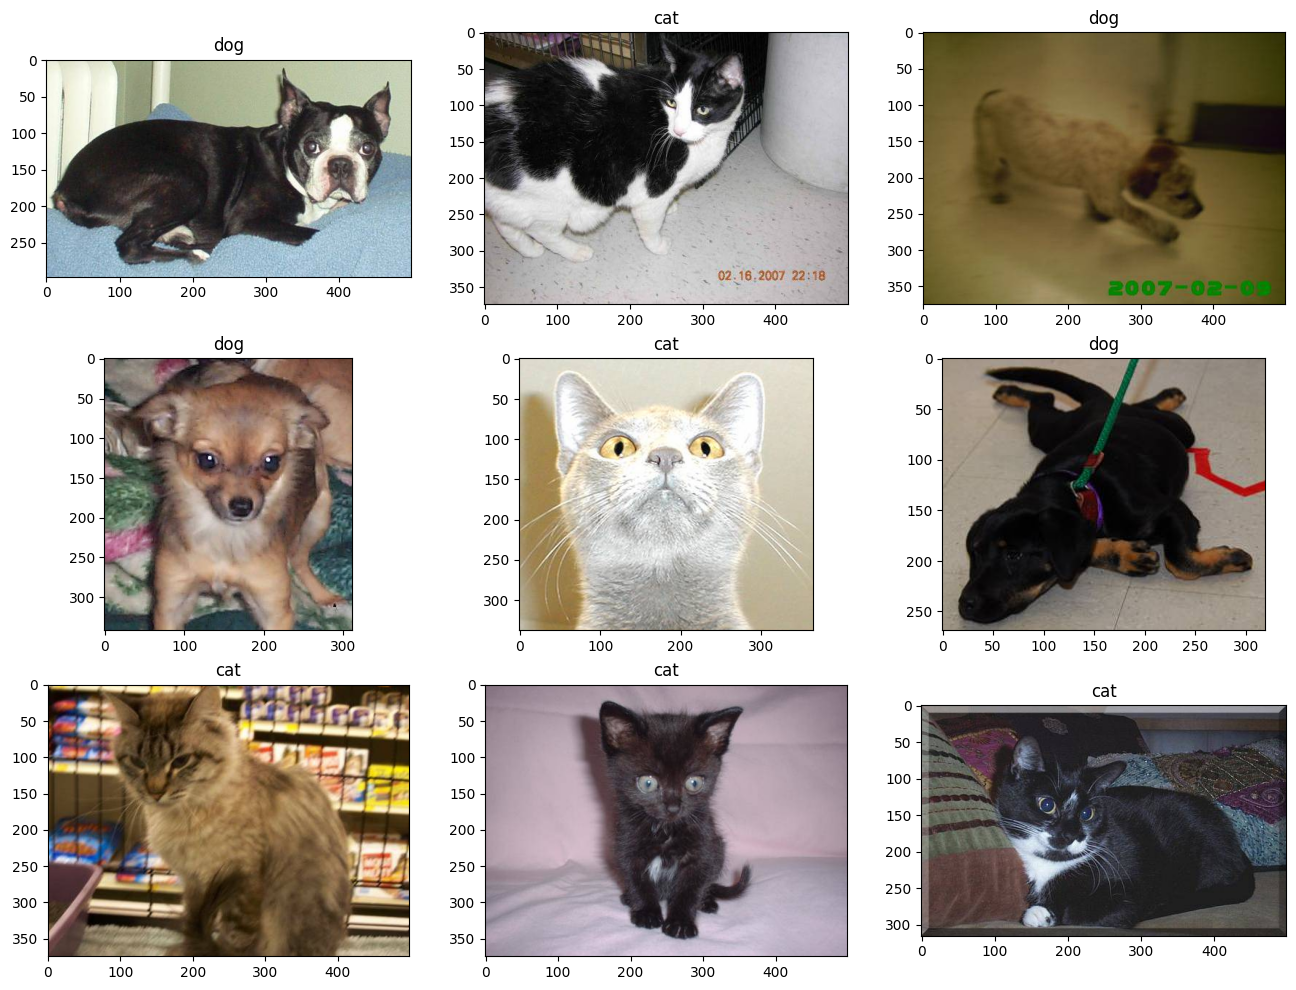

In [15]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[random_idx[idx]])
    ax.set_title(labels[random_idx[idx]])
    ax.imshow(img)


In [14]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [15]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224), # 随机裁剪为224×224（数据增强）
        transforms.RandomHorizontalFlip(), # 随机水平翻转（数据增强）
        transforms.ToTensor(), # 转换为Tensor格式，进行归一化
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [16]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("\\")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [17]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [18]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [19]:
print(len(train_data), len(train_loader)) # 20000/64=312.5

20000 313


In [20]:
from vit_pytorch.simple_vit import SimpleViT
# 定义模型参数
# dim = heads × dim_head：128 = 8 × 16，计算正确
# image_size 能被 patch_size 整除：224 ÷ 32 = 7，无余数
model_config = {
    "image_size": 224,          # 输入图像尺寸 (224x224)
    "patch_size": 32,           # patch 尺寸 (16x16)
    "num_classes": 2,        # 分类类别数
    "dim": 192,                 # 嵌入维度
    "depth": 8,                # Transformer 层数
    "heads": 12,                # 注意力头数
    "mlp_dim": 768,            # MLP 隐藏层维度
    "channels": 3,              # 输入图像通道数 (RGB)
    "dim_head": int(192/12)              # 每个注意力头的维度
}

# 初始化模型
model = SimpleViT(**model_config)

In [21]:
# 优化器配置
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=0.05
)

# CrossEntropyLoss接受整数标签
criterion = torch.nn.CrossEntropyLoss()  # 适用于单标签二分类

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [22]:
for imgs, labels in train_loader:
    print(f"Data shape: {imgs.shape}, Label shape: {labels.shape}")
    break

Data shape: torch.Size([64, 3, 224, 224]), Label shape: torch.Size([64])


In [24]:
model.to(device)  # 将模型移至设备（GPU或CPU）
for epoch in range(epochs):
    # 训练模式：启用 dropout、批量归一化更新
    model.train()
    epoch_loss_all_epoch = 0.0
    epoch_accuracy_all_epoch = 0.0

    for batch_idx, (data, label) in enumerate(train_loader):
        # 数据移至设备
        data = data.to(device)
        label = label.to(device)

        # 前向传播(64,2)
        output = model(data)  # SimpleViT输出形状：[batch_size, num_classes]
        loss = criterion(output, label)

        # 反向传播与优化
        optimizer.zero_grad(set_to_none=True)  # 更高效的梯度清零
        loss.backward()
        # 梯度裁剪（可选，防止梯度爆炸，对Transformer有效）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # 计算准确率
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy_all_epoch += acc.item()  # 累加当前批次准确率
        epoch_loss_all_epoch += loss.item()     # 累加当前批次损失

        # 打印批次信息（可选，监控训练进度）
        if (batch_idx + 1) % 50 == 0:
            print(f"Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f} - Acc: {acc.item():.4f}")

    # 计算训练集平均损失和准确率
    epoch_loss_all_epoch /= len(train_loader)
    epoch_accuracy_all_epoch /= len(train_loader)

    torch.save(model.state_dict(), f'simple_vit_final_model_epoch{epoch}.pth')

    # 验证模式：关闭 dropout、固定批量归一化参数
    model.eval()
    best_val_acc = 0.0
    epoch_val_accuracy = 0.0
    epoch_val_loss = 0.0

    with torch.no_grad():  # 禁用梯度计算，节省内存
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc.item()
            epoch_val_loss += val_loss.item()

    # 计算验证集平均损失和准确率
    epoch_val_loss /= len(valid_loader)
    epoch_val_accuracy /= len(valid_loader)

    # 更新学习率调度器
    scheduler.step()

    # 打印 epoch 结果
    print(
        f"\nEpoch {epoch+1}/{epochs}\n"
        f"Train - Loss: {epoch_loss_all_epoch:.4f} | Acc: {epoch_accuracy_all_epoch:.4f}\n"
        f"Valid - Loss: {epoch_val_loss:.4f} | Acc: {epoch_val_accuracy:.4f}\n"
        f"LR: {optimizer.param_groups[0]['lr']:.6f}\n"
    )

    # 保存最佳模型（仅保存验证准确率最高的模型）
    if epoch_val_accuracy > best_val_acc:
        best_val_acc = epoch_val_accuracy
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc
        }, 'simple_vit_best_model.pth')
        print(f"Saved best model (Val Acc: {best_val_acc:.4f})\n")

# 训练结束后保存最终模型
torch.save(model.state_dict(), 'simple_vit_final_model.pth')

Batch 50/313 - Loss: 0.6411 - Acc: 0.6250
Batch 100/313 - Loss: 0.5736 - Acc: 0.7031
Batch 150/313 - Loss: 0.6531 - Acc: 0.6875
Batch 200/313 - Loss: 0.6292 - Acc: 0.6406
Batch 250/313 - Loss: 0.6829 - Acc: 0.6094
Batch 300/313 - Loss: 0.6137 - Acc: 0.6094

Epoch 1/2
Train - Loss: 0.6359 | Acc: 0.6325
Valid - Loss: 0.6072 | Acc: 0.6669
LR: 0.000049

Saved best model (Val Acc: 0.6669)

Batch 50/313 - Loss: 0.6791 - Acc: 0.5781
Batch 100/313 - Loss: 0.6434 - Acc: 0.6406
Batch 150/313 - Loss: 0.6217 - Acc: 0.6406
Batch 200/313 - Loss: 0.5759 - Acc: 0.7031
Batch 250/313 - Loss: 0.6327 - Acc: 0.6562
Batch 300/313 - Loss: 0.5834 - Acc: 0.6562

Epoch 2/2
Train - Loss: 0.6116 | Acc: 0.6580
Valid - Loss: 0.5852 | Acc: 0.6883
LR: 0.000034

Saved best model (Val Acc: 0.6883)



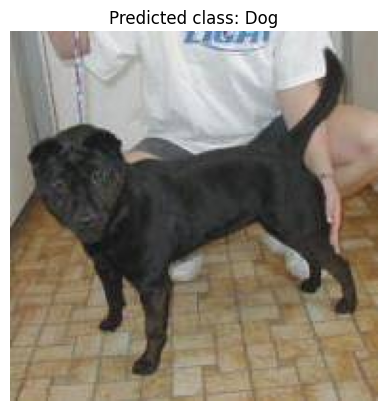

In [27]:
predModel = SimpleViT(**model_config)
predModel.load_state_dict(torch.load('simple_vit_best_model.pth')['model_state_dict'])
predModel.to(device)
# 测试集预测
predModel.eval()


# 加载单张图片进行推理
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')  # 打开并转换为RGB模式
    image = test_transforms(image).unsqueeze(0)  # 预处理并增加一个批次维度
    image = image.to(device)  # 移动到指定设备

    with torch.no_grad():
        output = model(image)  # 进行推理
        prediction = output.argmax(dim=1)  # 获取预测结果
        return prediction.item()  # 返回预测类别

# 示例：对单张图片进行推理
image_path = r'data\test\151.jpg'  # 替换为你的图片路径
predicted_class = predict_image(image_path)

# 可视化结果
# 显示图像和预测结果
image = Image.open(image_path)
plt.imshow(image)
plt.title('Predicted class: ' + ('Cat' if predicted_class == 0 else 'Dog'))  # 0为猫，1为狗
plt.axis('off')  # 关闭坐标轴
plt.show()